In [62]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([11.831951, 10.97954 , 10.355452, 11.704408,  7.838583,  9.804349,
        8.390662,  7.817971, 10.453527, 10.878577, 10.700631, 13.45151 ],
      dtype=float32)

In [64]:
chunks_range = range(SEQ_LEN-1, 1160, SEQ_LEN)

In [65]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [66]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 100, 80, 3),
 '/home/beans/blender_membank/dataloader_06/run_21')

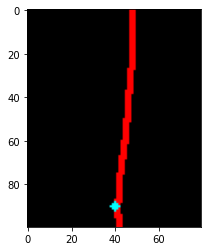

In [67]:
plt.imshow(maps[550])

In [68]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

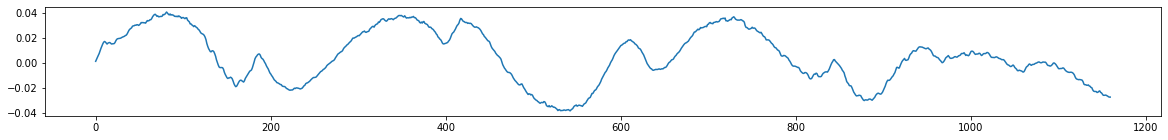

In [69]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

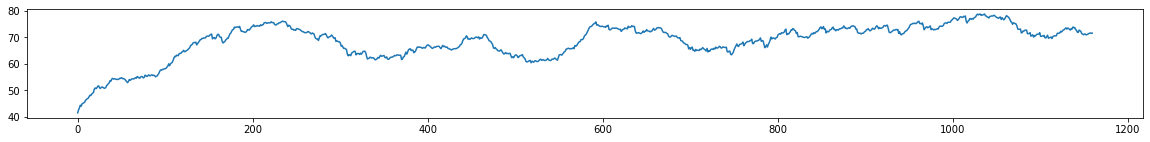

In [70]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [71]:
ix = 1000

In [72]:
t = smooth_near_wps(targets[ix])

In [73]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [74]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

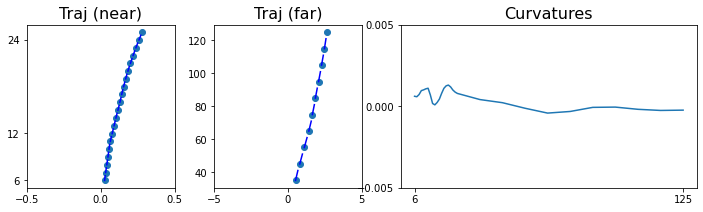

In [75]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

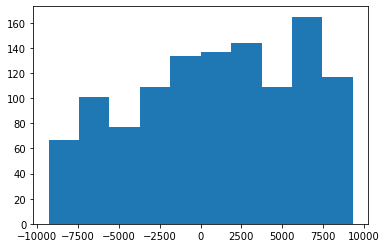

In [76]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

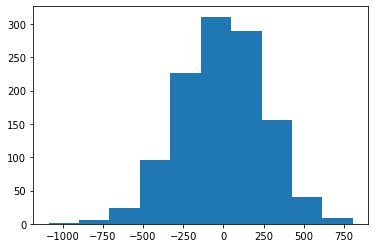

In [77]:
plt.hist(torque[1:]-torque[:-1])[2]

In [78]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [79]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-80:,:] = np.fliplr(maps[i])
    
    video.write(img)
    
video.release()

In [80]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-80:,:] = np.fliplr(maps[i])

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "8.22_avg"
rollout_data = make_vid(run_id, model_stem, imgs, aux_vid, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)


/home/beans/bespoke/viz_utils.py:59: RuntimeWarning: invalid value encountered in true_divide
  act_grad = act_grad/m


Made vid!


In [84]:
np.cos(.0)

1.0

In [19]:
combine_vids("8.9_avg", "8.9_avgTrain", "sim")

combined!


In [267]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [23]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 165.,  323.,  368.,  670.,  868., 1164., 1025.,  626.,  446.,
         145.]),
 array([-0.06666353, -0.05459857, -0.04253361, -0.03046865, -0.01840369,
        -0.00633873,  0.00572622,  0.01779118,  0.02985614,  0.0419211 ,
         0.05398606], dtype=float32),
 <BarContainer object of 10 artists>)

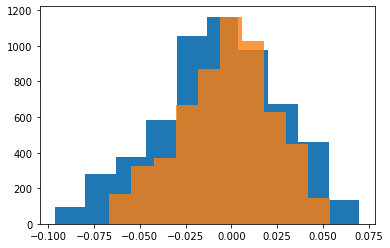

In [24]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

(array([ 79., 325., 488., 731., 949., 890., 794., 910., 536.,  98.]),
 array([-0.09078395, -0.07428899, -0.05779405, -0.0412991 , -0.02480415,
        -0.0083092 ,  0.00818575,  0.0246807 ,  0.04117565,  0.0576706 ,
         0.07416555], dtype=float32),
 <BarContainer object of 10 artists>)

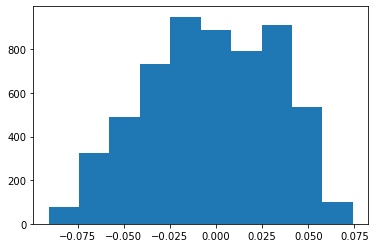

In [162]:
obsnet_outs.shape

(1160, 3)

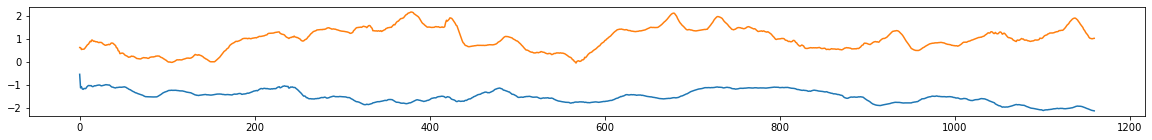

In [163]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [164]:
aux[0]

array([-1.5071025e+00,  6.1787933e-01,  3.4964561e+01,  0.0000000e+00,
       -3.0346576e-03], dtype=float32)

In [35]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_run_paths.append(run_path)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 0 out of 360 runs


In [36]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 4.99 s, sys: 0 ns, total: 4.99 s
Wall time: 4.99 s


In [37]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [38]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((360, 1160, 30), (360, 1160, 30), (360, 1160, 30), (360, 1160, 30))

In [91]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .05:
        print(i, m)
        mm += 1

46 0.05429928
94 0.12506151
133 0.059301317
151 0.051751494
153 0.06602016
205 0.08772296
267 0.056077853
298 0.066411644


In [92]:
all_run_paths[46]

'/home/beans/blender_membank/dataloader_01/run_16'

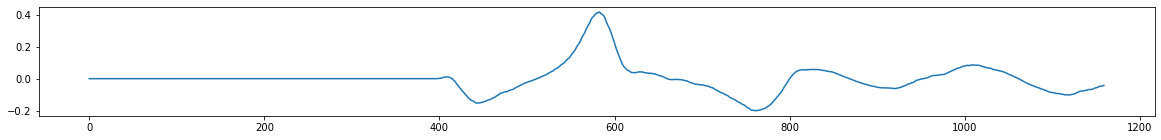

In [59]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[94,:,0])

<BarContainer object of 40 artists>

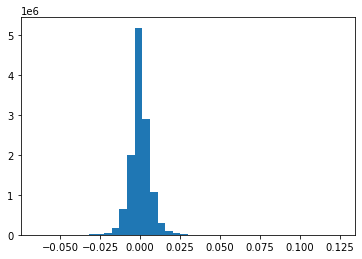

In [43]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [74]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

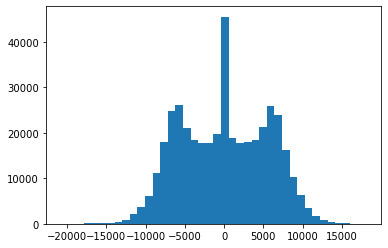

In [75]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

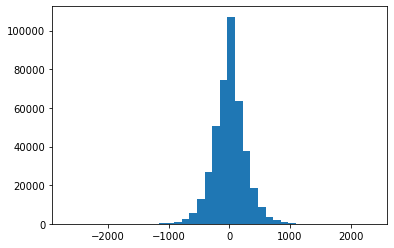

In [76]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [77]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1179.360964795428, 14996.567836924865)

In [78]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.9946322,   6.9937086,   7.9927263,   8.991661 ,   9.990531 ,
        10.989307 ,  11.988011 ,  12.986574 ,  13.985039 ,  14.983383 ,
        15.9816065,  16.979685 ,  17.977642 ,  18.975458 ,  19.97309  ,
        20.970478 ,  21.967806 ,  22.964949 ,  23.961885 ,  24.958618 ,
        34.91493  ,  44.84812  ,  54.75625  ,  64.638626 ,  74.495285 ,
        84.326965 ,  94.13432  , 103.9186   , 113.68138  , 123.42368  ],
      dtype=float32)

<BarContainer object of 40 artists>

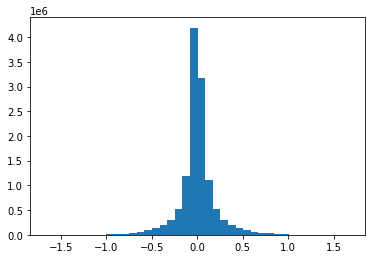

In [79]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [80]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02570073, 0.02975405, 0.03378967, 0.0378296 , 0.04187217,
       0.04591462, 0.04994678, 0.05396116, 0.05795977, 0.06194375,
       0.06590954, 0.06985426, 0.07377764, 0.0776792 , 0.08155717,
       0.08540933, 0.08923666, 0.09303882, 0.0968121 , 0.10047626,
       0.13510366, 0.16717426, 0.19563614, 0.22048618, 0.24182415,
       0.25967628, 0.27432853, 0.28640124, 0.29612383, 0.30108848],
      dtype=float32)

In [81]:
mean_headings[-1] / mean_headings[0]

11.715174

In [82]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01612604, 0.01774818, 0.0194726 , 0.02126269, 0.02309838,
       0.02496745, 0.02686084, 0.02877109, 0.03069213, 0.03262105,
       0.03455506, 0.03649165, 0.03842905, 0.04036589, 0.0423009 ,
       0.04423283, 0.04616069, 0.04808384, 0.05000108, 0.05191189,
       0.07054599, 0.08807871, 0.1043399 , 0.119243  , 0.13276537,
       0.14490801, 0.15570004, 0.16520412, 0.1735052 , 0.18070588],
      dtype=float32)

In [83]:
mean_angles[-1] / mean_angles[0]

11.205842

In [84]:
mean_angles[0] / .015

1.0750694821278255

<BarContainer object of 40 artists>

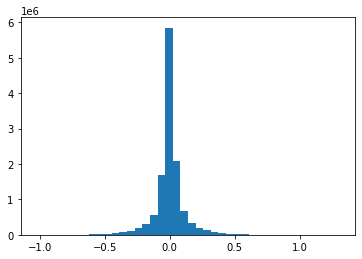

In [85]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

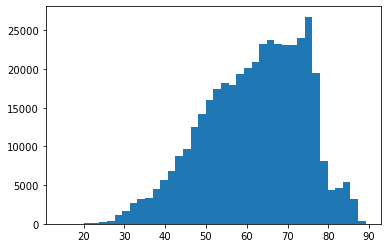

In [86]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

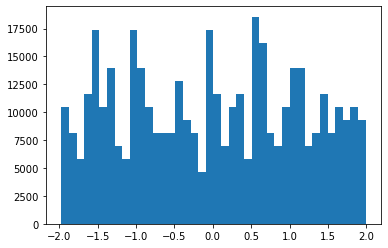

In [87]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

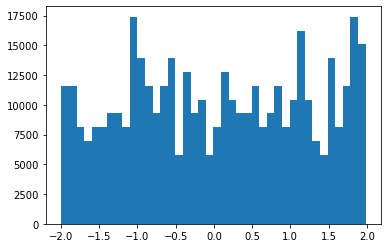

In [88]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]